In [1]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashpraveshs22","key":"5f8ea32b1b3aad435902a3b249492aac"}'}

#  PCA and classification of MNIST data


**What is Principal Component Analysis (PCA)?**

Principal Component Analysis (PCA), which is a way to learn without being watched, is one of the many important ideas in Data Science. It is often used to reduce the number of dimensions in large datasets or make them easier to understand. It does this by turning a large set of variables into a small set of variables while keeping most of the change in the dataset. PCA lowers the amount of data by projecting it in a geometric way onto smaller dimensions, which are called Principal Components (PC). The goal of this method is to find the best summary of our data by using the fewest number of principal components. When we choose our principal components, we choose them so that the distance between the original data and the numbers projected on the principal components is as small as possible.

In [ ]:
# Import Libraries
%matplotlib inline
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
import keras
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh

In [ ]:
# Load the Dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train = train['label']
X_train = train.drop(['label'], axis=1)
X_test = test
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

Data Normalization

In [ ]:
X_train = X_train/255
X_test = X_test/255

IMAGE LABEL: 0


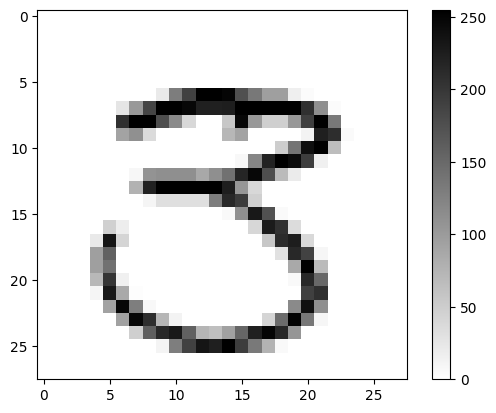

In [ ]:
# Visualize single digit
digit_array = train.loc[7, "pixel0":]
arr = np.array(digit_array) 

#.reshape(a, (28,28))
image_array = np.reshape(arr, (28,28))

digit_img = plt.imshow(image_array, cmap=plt.cm.binary)
plt.colorbar(digit_img)
print("IMAGE LABEL: {}".format(train.loc[5, "label"]))

In [ ]:
standardized_scalar = StandardScaler()
standardized_data = standardized_scalar.fit_transform(X_train)
standardized_data.shape

(784, 784)

In [ ]:
cov_matrix = np.matmul(standardized_data.T, standardized_data)
cov_matrix.shape

(784, 784)

In [ ]:
#EigenValues and EigenVectors
lambdas, vectors = eigh(cov_matrix, eigvals=(782, 783))
vectors.shape

<ipython-input-64-1273f0ff29a5>:2: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  lambdas, vectors = eigh(cov_matrix, eigvals=(782, 783))


(784, 2)

In [ ]:
vectors = vectors.T
vectors.shape

(2, 784)

In [ ]:
#Calculate unit vectors U1=V1 and new coordinates
new_coordinates = np.matmul(vectors, standardized_data.T)
print(new_coordinates.shape)
new_coordinates = np.vstack((new_coordinates, y_train)).T

(2, 42000)


In [ ]:
df_new = pd.DataFrame(new_coordinates, columns=["f1", "f2", "labels"])
df_new.head()

,f1,f2,labels
0,-5.226445,-5.140478,1.0
1,6.032996,19.292332,0.0
2,-1.705813,-7.644503,1.0
3,5.836139,-0.474207,4.0
4,6.024818,26.559574,0.0


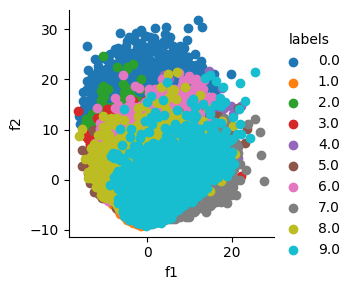

In [ ]:
sns.FacetGrid(df_new, hue="labels").map(plt.scatter, "f1", "f2").add_legend()
plt.show()

**CNN Model**

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

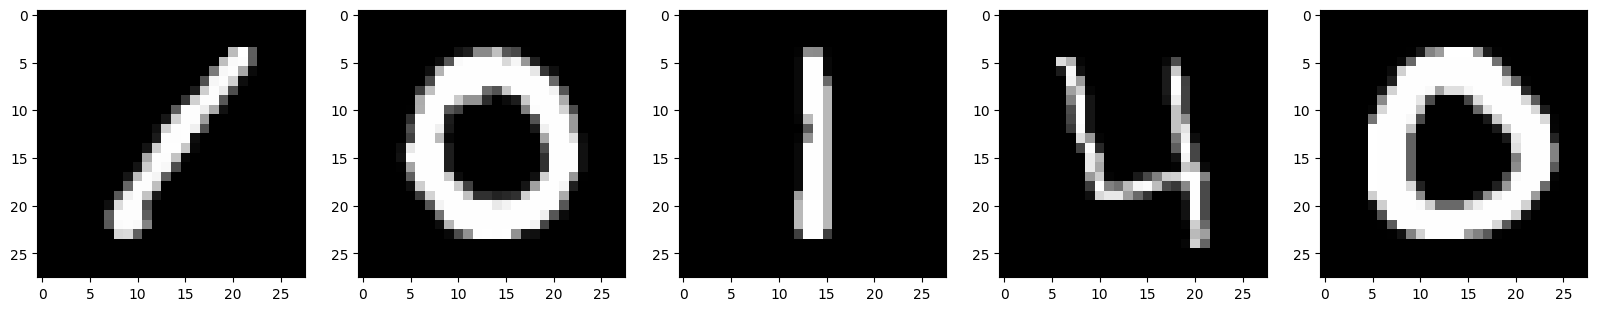

In [ ]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(X_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
print(X_train.shape, y_train.shape)

(42000, 28, 28, 1) (42000,)


In [ ]:
nclasses = y_train.max() - y_train.min() + 1
y_train = to_categorical(y_train, num_classes = nclasses)
print("Shape of ytrain after encoding --> ", y_train.shape)

Shape of ytrain after encoding -->  (42000, 10)


In [ ]:
input_shape = (28,28,1)
X_input = Input(input_shape)

# layer 1
x = Conv2D(64,(3,3),strides=(1,1),name='layer_conv1',padding='same')(X_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool1')(x)


# layer 2
x = Conv2D(32,(3,3),strides=(1,1),name='layer_conv2',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool2')(x)


# layer 3
x = Conv2D(32,(3,3),strides=(1,1),name='conv3',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2), name='maxPool3')(x)


# FullyConnected Layer
x = Flatten()(x)
x = Dense(64,activation ='relu',name='fc0')(x)
x = Dropout(0.25)(x)
x = Dense(32,activation ='relu',name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(10,activation ='softmax',name='fc2')(x)
conv_model = Model(inputs=X_input, outputs=x, name='Predict')
conv_model.summary()

Model: "Predict"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 layer_conv1 (Conv2D)        (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 28, 28, 64)        0         
                                                                 
 maxPool1 (MaxPooling2D)     (None, 14, 14, 64)        0         
                                                                 
 layer_conv2 (Conv2D)        (None, 14, 14, 32)        18464     
                                                           

In [ ]:
def compile_model(conv_model, optimizer='adam', loss='categorical_crossentropy'):
    conv_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    
    
def train_model(conv_model, train, test, epochs, split):
    history = conv_model.fit(train, test, shuffle=True, epochs=epochs, batch_size=100,validation_split=split)
    return history

In [ ]:
# Training the model using the above function built to build, compile and train the model
compile_model(conv_model, 'adam', 'categorical_crossentropy')

# train the model for as m                                                                                 any epochs as you want but I found training it above 80 will not help us and eventually increase overfitting.
model_history = train_model(conv_model, X_train, y_train, 10, 0.2)

Epoch 1/10
336/336 [==============================] - 63s 184ms/step - loss: 0.4451 - accuracy: 0.8618 - val_loss: 0.1065 - val_accuracy: 0.9723
Epoch 2/10
336/336 [==============================] - 55s 163ms/step - loss: 0.1431 - accuracy: 0.9605 - val_loss: 0.0630 - val_accuracy: 0.9825
Epoch 3/10
336/336 [==============================] - 52s 154ms/step - loss: 0.1010 - accuracy: 0.9724 - val_loss: 0.0522 - val_accuracy: 0.9848
Epoch 4/10
336/336 [==============================] - 52s 155ms/step - loss: 0.0789 - accuracy: 0.9794 - val_loss: 0.0616 - val_accuracy: 0.9814
Epoch 5/10
336/336 [==============================] - 53s 157ms/step - loss: 0.0694 - accuracy: 0.9811 - val_loss: 0.0841 - val_accuracy: 0.9780
Epoch 6/10
336/336 [==============================] - 52s 155ms/step - loss: 0.0600 - accuracy: 0.9834 - val_loss: 0.0401 - val_accuracy: 0.9888
Epoch 7/10
336/336 [==============================] - 54s 159ms/step - loss: 0.0484 - accuracy: 0.9863 - val_loss: 0.0682 - val_ac

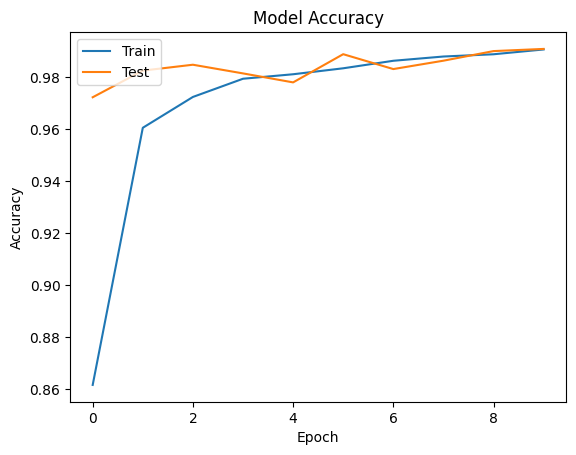

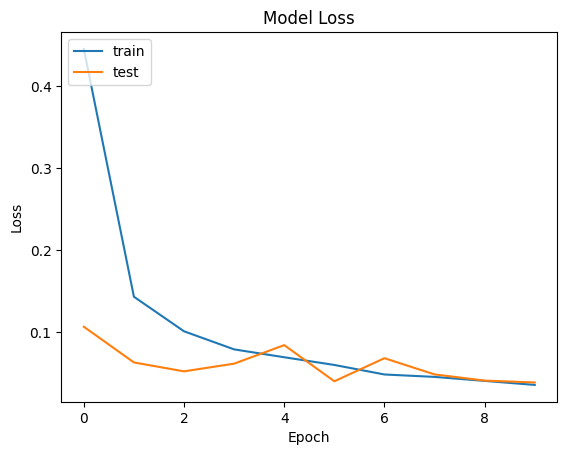

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Model_Accuracy.png')
plt.show()
                                                          
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Model_loss.png')
plt.show()